In [1]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np

Instructions for updating:
Use the retry module or similar alternatives.


#### 1. 将输入转化成TFRecord格式并保存。

In [6]:
## 
 # 把所有数据转换成「tf.train.Feature」格式
##
def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

##
 # 把所有的「tf.train.Features」组合成「tf.train.Example」格式
##
def _make_example(pixels, label, image):
    image_raw = image.tostring()
    example = tf.train.Example(features=tf.train.Features(feature={
        'pixels': _int64_feature(pixels),
        'label': _int64_feature(np.argmax(label)),
        'image_raw': _bytes_feature(image_raw)
    }))
    return example

# 读取mnist训练数据。
mnist = input_data.read_data_sets("../../datasets/MNIST_data",dtype=tf.uint8, one_hot=True)
images = mnist.train.images # (55000, 784)
labels = mnist.train.labels # (55000, 10),手写数字(0-9)的类标签
pixels = images.shape[1] # 训练数据对用的图像像素作为Example中的一个属性存储（28x28=784）
num_examples = mnist.train.num_examples

# 输出包含训练数据的TFRecord文件
filename = "../../datasets/mnist_train_data.tfrecord"
with tf.python_io.TFRecordWriter(filename) as writer:
    for index in range(num_examples):
        example = _make_example(pixels, labels[index], images[index])
        writer.write(example.SerializeToString())
print("TFRecord训练文件已保存。")

Extracting ../../datasets/MNIST_data\train-images-idx3-ubyte.gz
Extracting ../../datasets/MNIST_data\train-labels-idx1-ubyte.gz
Extracting ../../datasets/MNIST_data\t10k-images-idx3-ubyte.gz
Extracting ../../datasets/MNIST_data\t10k-labels-idx1-ubyte.gz
TFRecord训练文件已保存。


#### 2. 读取TFRecord文件

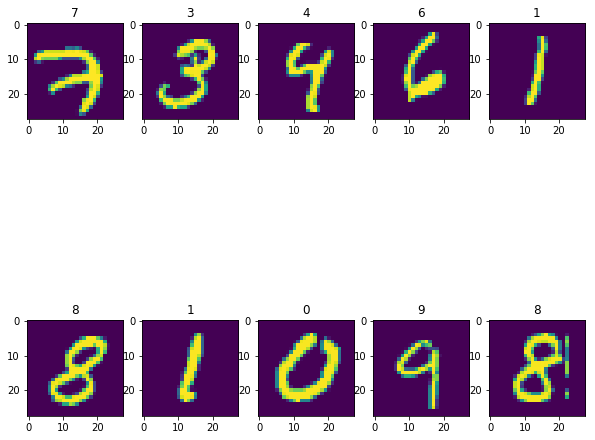

In [5]:
# 使用tf.string_input_producer产生文件名队列
filename = ["../../datasets/mnist_train_data.tfrecord"] # 列表
filename_queue = tf.train.string_input_producer(filename) 

reader = tf.TFRecordReader()
_,serialized_example = reader.read(filename_queue) # 从文件中读取一个样例

# 解析读取的样例。
features = tf.parse_single_example(
    serialized_example,
    features={
        'image_raw':tf.FixedLenFeature([], tf.string),
        'pixels':tf.FixedLenFeature([], tf.int64),
        'label':tf.FixedLenFeature([], tf.int64)
    })

# tf.decode_row可以将字符串解析成图像对应的像素数组
images = tf.decode_raw(features['image_raw'], tf.uint8)

# tf.cast()函数的作用是执行tensorflow中张量数据类型转换
labels = tf.cast(features['label'], tf.int32)
pixels = tf.cast(features['pixels'], tf.int32)

sess = tf.Session()

# 启动多线程处理输入数据。
coord = tf.train.Coordinator()
threads = tf.train.start_queue_runners(sess=sess,coord=coord)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for i in range(10):
    image, label, pixel = sess.run([images, labels, pixels])
    image_origin = image.reshape(28, 28)
    plt.subplot(2, 5, i+1)
    plt.title(label)
    plt.imshow(image_origin)